<a href="https://www.kaggle.com/code/evanupham/stt-conv-nn?scriptVersionId=183892983" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

https://huggingface.co/UphamProjects/STT-Gated_TCN

So this isn't perfect by any means, but at 3m params I can go through an epoch in under a minute for 15k+ dataset.  It's using mixed precision.  Initially I was going to use an attention mechanism before each residual block, but that was slow, didn't do anything good withing the range of my parameter search, and so I replaced it with GPT assures me is a gating mechanism.  After the tcn and a transpose I do a layer norm and dropout; the idea here is that it stablizes my mixed precision.

My data loading is garbage, I need to handle vocab better.  I've also figured out how to get some of my model on huggingface as it trains, but don't expect that to work very well yet.  I need to start capturing wer and other metrics too.  Messing around with some other concepts I don't fully comprehend.

I've messed around with representing the mfcc as db instead of magnetude because I read an article, not seeing any significant gains, maybe worse quality actually.  Just watch I'll roll it back and not be able to get it to drop below a loss of 5.

So I've played around with 12m parameters.  It takes just over 3 minutes here and 7 minutes on colab or with mixed precision about 2 minutes per epoch for both platforms.  I've added an init weights that helps some, but the bigger thing that allows the model to work here is gradual unfreezing.  With gradual unfreezing (tested on colab not here yet) it lets me train with mixed precision and acchieve some level of transcription.  I tried adding pruning but keep getting nan eventually.

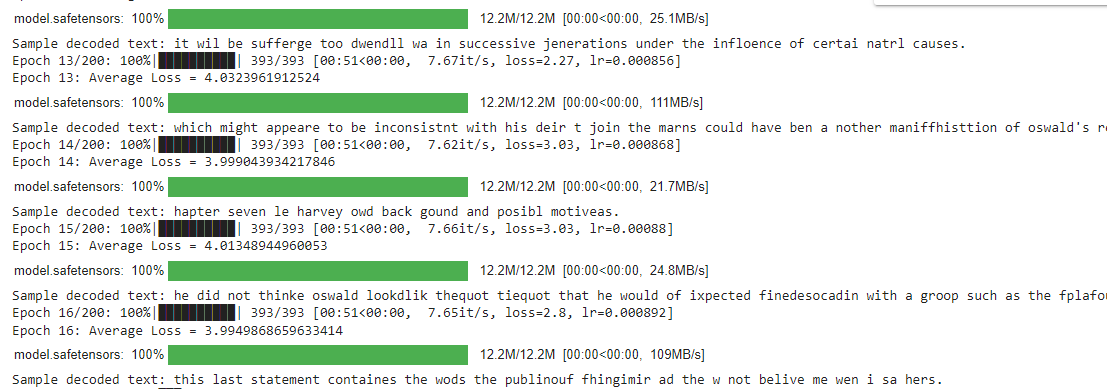

In [1]:
!pip install librosa datasets huggingface_hub

In [2]:
from huggingface_hub import notebook_login
notebook_login()


###### 

In [ ]:
# import torch
# import numpy as np
# import pandas as pd
# import librosa
# from sklearn.model_selection import train_test_split
# from tqdm.auto import tqdm
# from datasets import load_dataset
# from torch.utils.data import DataLoader, TensorDataset
# import os
# import json
# from transformers import GPT2Tokenizer
# from torch.nn.parallel import DataParallel

# # Constants
# BATCH_SIZE = 32
# NUM_EPOCHS = 30
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Load datasets
# fleurs_dataset = load_dataset("google/fleurs", "en_us", split='train')
# lj_dataset = load_dataset("lj_speech", split='train')

# # Combine transcription data into one DataFrame for consistent tokenization
# transcriptions_fleurs = pd.DataFrame(fleurs_dataset['transcription'], columns=['transcription'])
# transcriptions_lj = pd.DataFrame(lj_dataset['normalized_text'], columns=['transcription'])
# all_transcriptions = pd.concat([transcriptions_lj]+[transcriptions_fleurs])

# import os
# from tokenizers import ByteLevelBPETokenizer

# def initialize_and_save_tokenizer(transcriptions, tokenizer_path='/kaggle/working/bpe_tokenizer.json', vocab_size=5000):
#     # Check if the tokenizer already exists
#     if False:
#         print("Tokenizer loaded from", tokenizer_path)
#         tokenizer = ByteLevelBPETokenizer(f"{tokenizer_path}-vocab.json", f"{tokenizer_path}-merges.txt")
#     else:
#         # Initialize a new tokenizer
#         tokenizer = ByteLevelBPETokenizer()

#         # Train the tokenizer
#         tokenizer.train_from_iterator(transcriptions, vocab_size=vocab_size, min_frequency=2, special_tokens=["<PAD>", "<s>", "</s>", "<unk>", "<mask>"])

#         # Save the tokenizer
#         os.makedirs(os.path.dirname(tokenizer_path), exist_ok=True)
#         tokenizer.save_model(os.path.dirname(tokenizer_path))

#         print("Tokenizer created and saved to", tokenizer_path)

#     return tokenizer

# # Load or create tokenizer
# tokenizer = initialize_and_save_tokenizer(all_transcriptions['transcription'].tolist())
# # Convert texts to sequences
# # Assuming tokenizer is an instance of ByteLevelBPETokenizer
# transcription_list = all_transcriptions['transcription'].tolist()

# # Encode all texts
# encodings = tokenizer.encode_batch(transcription_list)

# # Extract input_ids from encodings
# sequences = [encoding.ids for encoding in encodings]

# # Finding the maximum sequence length
# max_sequence_len = max(len(seq) for seq in sequences)

# # Pad sequences manually since ByteLevelBPETokenizer doesn't automatically pad
# sequences_padded = [seq + [tokenizer.token_to_id('<PAD>')] * (max_sequence_len - len(seq)) for seq in sequences]

# # Feature extraction
# def load_extract_features(audio, sr, add_noise=True, pitch_shift=True, time_stretch=True):
#     # Randomly add noise
    
#     # Compute MFCC features
#     mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
#     mfcc_db = librosa.power_to_db(mfcc)
    
#     features = np.vstack([mfcc_db])
#     return features.T

# features_fleurs = [load_extract_features(sample['audio']['array'], sample['audio']['sampling_rate']) for sample in tqdm(fleurs_dataset, desc="Extracting features FLEURS")]
# features_lj = [load_extract_features(sample['audio']['array'], sample['audio']['sampling_rate']) for sample in tqdm(lj_dataset, desc="Extracting features LJ Speech")]

# # Combine and pad features
# features_list = features_lj + features_fleurs
# max_len = max(max([feature.shape[0] for feature in features_list]), max_sequence_len)
# features_padded = np.array([np.pad(feature, ((0, max_len - feature.shape[0]), (0, 0)), 'constant', constant_values=0) for feature in features_list])
# sequences_padded = np.array([np.pad(seq, (0, max_len - len(seq)), 'constant', constant_values=0) for seq in sequences_padded])

# # Split data
# X_train, X_test, y_train, y_test = train_test_split(features_padded, sequences_padded, test_size=0.2, random_state=42)
# X_train_torch = torch.tensor(X_train, dtype=torch.float32)
# X_test_torch = torch.tensor(X_test, dtype=torch.float32)
# y_train_torch = torch.tensor(y_train, dtype=torch.long).squeeze()
# y_test_torch = torch.tensor(y_test, dtype=torch.long).squeeze()

# # DataLoader
# train_loader = DataLoader(TensorDataset(X_train_torch, y_train_torch), batch_size=BATCH_SIZE, shuffle=True)
# val_loader = DataLoader(TensorDataset(X_test_torch, y_test_torch), batch_size=BATCH_SIZE, shuffle=True)

# Leave all function calls and method calls commented out for now.
from re import L

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import math
from torch.optim.lr_scheduler import CyclicLR

# Temporal Convolutional Network (TCN) Model Definition

class BSplineConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, num_knots, stride=1, padding=0, dilation=1, groups=1):
        super(BSplineConv1d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.num_knots = num_knots
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.groups = groups
        
        # Ensure the number of input and output channels is divisible by the number of groups
        assert in_channels % groups == 0, 'in_channels must be divisible by groups'
        assert out_channels % groups == 0, 'out_channels must be divisible by groups'
        
        # B-spline coefficients and knot vector
        self.coefficients = nn.Parameter(torch.randn(out_channels, in_channels // groups, kernel_size))
        self.knots = torch.linspace(0, 1, num_knots + kernel_size).unsqueeze(0).unsqueeze(0)
        self.bias = nn.Parameter(torch.randn(out_channels))
        
    def bspline_basis(self, u, knots):
        k = knots.size(-1) - u.size(-1) - 1
        N = torch.zeros_like(u)
        for i in range(k + 1):
            d_i = knots[..., i:i + u.size(-1) + 1]
            numer = (u - d_i[..., :-1])
            denom = (d_i[..., 1:] - d_i[..., :-1])
            basis = torch.where(denom != 0, numer / denom, torch.zeros_like(numer))
            N += torch.prod(torch.clamp(basis, min=0), dim=-1)
        return N
    
    def forward(self, x):
        # Pad the input
        x = F.pad(x, (self.padding, self.padding))
        
        # Unfold input into patches
        batch_size, in_channels, length = x.size()
        kernel_size_dilated = (self.kernel_size - 1) * self.dilation + 1
        out_length = (length - kernel_size_dilated) // self.stride + 1
        
        unfolded = x.unfold(2, kernel_size_dilated, self.stride)
        unfolded = unfolded[:, :, :, ::self.dilation]
        
        # Evaluate B-spline basis
        u = torch.linspace(0, 1, self.kernel_size, device=x.device).unsqueeze(0).unsqueeze(0)
        B = self.bspline_basis(u, self.knots.to(x.device))
        
        # Correctly reshape and expand B
        B = B.squeeze().unsqueeze(0).unsqueeze(1).expand(self.coefficients.size(0), self.coefficients.size(1), self.coefficients.size(2), -1)
        
        # Manually compute B-spline weighted values
        splined_weights = torch.einsum('oik, oikl -> oikl', self.coefficients, B)
        
        # Perform convolution using B-spline evaluated values directly
        out = torch.zeros(batch_size, self.out_channels, out_length, device=x.device)
        
        for g in range(self.groups):
            x_group = unfolded[:, g * (in_channels // self.groups):(g + 1) * (in_channels // self.groups), :, :]
            weights_group = splined_weights[g * (self.out_channels // self.groups):(g + 1) * (self.out_channels // self.groups), :, :, :]
            out[:, g * (self.out_channels // self.groups):(g + 1) * (self.out_channels // self.groups), :] = torch.einsum('bijk, oikl -> boj', x_group, weights_group)
        
        out += self.bias.unsqueeze(0).unsqueeze(2)
        return out

# Test the BSplineConv1d layer
batch_size = 2
in_channels = 4
out_channels = 8
kernel_size = 3
num_knots = 4
length = 16
stride = 1
padding = 1
dilation = 1
groups = 2

x = torch.randn(batch_size, in_channels, length)
model = BSplineConv1d(in_channels, out_channels, kernel_size, num_knots, stride, padding, dilation, groups)
output = model(x)

print(output.shape)

    
class DropBlock(nn.Module):
    def __init__(self, drop_prob, block_size):
        super(DropBlock, self).__init__()
        self.drop_prob = drop_prob
        self.block_size = block_size

    def forward(self, x):
        if not self.training or self.drop_prob == 0.0:
            return x
        gamma = self._compute_gamma(x)
        mask = (torch.rand(x.shape[:2]) < gamma).float().to(x.device)
        block_mask = self._compute_block_mask(mask, x.shape)
        out = x * block_mask[:, :, None]
        out = out * (block_mask.numel() / block_mask.sum())
        return out

    def _compute_block_mask(self, mask, shape):
        batch_size, channels, length = shape
        block_mask = F.max_pool1d(mask.unsqueeze(1), self.block_size, stride=1, padding=self.block_size // 2)
        block_mask = 1 - block_mask.squeeze(1)
        return block_mask

    def _compute_gamma(self, x):
        return self.drop_prob * (x.shape[2] ** 2) / (self.block_size ** 2) / (
            (x.shape[2] - self.block_size + 1) ** 2)

class DSC(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation_size, padding, dropout):
        super(DSC, self).__init__()
        self.depthwise = BSplineConv1d(in_channels, in_channels, kernel_size,
                                   stride=1, padding=padding, dilation=dilation_size, groups=in_channels, num_knots=10)
        self.pointwise = BSplineConv1d(in_channels, out_channels, 1, num_knots=10)
        self.bn = nn.BatchNorm1d(out_channels)
        self.silu = nn.SiLU()
        self.dropout = DropBlock(drop_prob=0.3, block_size=5)  # Using DropBlock instead of Dropout

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.bn(x)
        x = self.silu(x)
        x = self.dropout(x)
        return x

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation_size, dropout):
        super(ResidualBlock, self).__init__()
        padding = (kernel_size - 1) * dilation_size // 2  # Ensure the output size is the same as the input size
        self.conv = DSC(in_channels, out_channels, kernel_size, dilation_size, padding, dropout)
        self.bn = nn.BatchNorm1d(out_channels)
        self.silu = nn.SiLU()
        self.downsample = BSplineConv1d(in_channels, out_channels, 1,num_knots=10) if in_channels != out_channels else None

    def forward(self, x):
        residual = x
        out = self.conv(x)

        if self.downsample is not None:
            residual = self.downsample(x)

        return self.silu(out + residual)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0)

    def forward(self, x):
        # Ensure positional encodings are up to the same length as the input and have correct feature size
        batch_size, seq_len, feature_size = x.shape
        device = x.device

        # Extend encoding to match batch size dynamically
        encoding = self.encoding[:, :seq_len].repeat(batch_size, 1, 1).to(device)

        if encoding.shape[2] != feature_size:
            # Adjust feature dimension of encoding if it doesn't match
            new_encoding = torch.zeros((batch_size, seq_len, feature_size), device=device)
            min_features = min(feature_size, encoding.shape[2])
            new_encoding[:, :, :min_features] = encoding[:, :, :min_features]
            encoding = new_encoding

        return x + encoding

class ConvGate(nn.Module):
    def __init__(self, channels, kernel_size=3):
        super(ConvGate, self).__init__()
        padding = kernel_size // 2
        
        # Convolution layers for gating
        self.conv_gate = BSplineConv1d(channels, channels, kernel_size, padding=padding, num_knots=10)
        self.conv_transform = BSplineConv1d(channels, channels, kernel_size, padding=padding, num_knots=10)
        
        # Attention mechanism components
        self.attention_weights = nn.Parameter(torch.randn(channels, 1))  # Learnable attention weights

        # Adaptive gate control
        self.adaptive_scale = nn.Parameter(torch.randn(1, channels, 1))  # Learnable scaling for the gate
        self.adaptive_bias = nn.Parameter(torch.randn(1, channels, 1))  # Learnable bias for the gate

        # Activation and normalization
        self.sigmoid = nn.Sigmoid()
        self.layer_norm = nn.LayerNorm(channels)  # Applying layer normalization per channel

    def forward(self, x):
        # Compute the gate using sigmoid activation
        gate = self.sigmoid(self.conv_gate(x) * self.adaptive_scale + self.adaptive_bias)
        
        # Apply the transformation
        transformed = self.conv_transform(x)
        
        # Apply attention by multiplying with the learnable weights
        attention = transformed * self.attention_weights

        # Element-wise multiplication of the gate and the attention-applied transformation
        gated_output = attention * gate
        
        # Adding a residual connection
        gated_output = gated_output + x
        
        # Layer normalization
        gated_output = self.layer_norm(gated_output.transpose(1, 2)).transpose(1, 2)

        return gated_output

class TCN(nn.Module):
    def __init__(self, num_features, num_classes, num_channels, kernel_size=3, dropout=0.2):
        super(TCN, self).__init__()
        self.pos_encoder = PositionalEncoding(num_features)
        layers = []
        num_levels = len(num_channels)

        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_features if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [ConvGate(in_channels)]
            layers += [ResidualBlock(in_channels, out_channels, kernel_size, dilation_size, dropout)]

        self.tcn = nn.Sequential(*layers)
        self.dropout = DropBlock(drop_prob=0.3, block_size=5)  # Using DropBlock instead of Dropout
        self.layer_norm = nn.LayerNorm(num_channels[-1])
        self.linear = nn.Linear(num_channels[-1], num_classes)
        self.mish = nn.Mish()
    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.pos_encoder(x)
        x = self.tcn(x)
        x = x.transpose(1, 2)
        x = self.dropout(x)
        x = self.layer_norm(x)
        x = self.mish(x)
        x = self.linear(x)
        return x



# Assuming DEVICE is set for GPU/CPU
num_features = features_padded.shape[2]
num_classes = tokenizer.get_vocab_size() + 1  # Includes space for the added padding token

tcn_model = TCN(num_features, num_classes, [1024, 1024, 2048, 2048], kernel_size=3, dropout=0.25)
tcn_model = tcn_model.to(DEVICE)

# If multiple GPUs are available, wrap the model with DataParallel
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    tcn_model = nn.DataParallel(tcn_model)
import torch.nn.init as init

def initialize_weights(model, sparsity=0.9):
    for m in model.modules():
        if isinstance(m, nn.Conv1d):
            # Sparse Kaiming He initialization
            fan_out = init._calculate_correct_fan(m.weight, 'fan_out')
            gain = init.calculate_gain('relu')
            std_dev = gain / fan_out ** 0.5
            with torch.no_grad():
                m.weight.normal_(0, std_dev)
                # Apply sparsity
                mask = torch.rand(m.weight.shape) < sparsity  # Mask with desired sparsity
                m.weight[mask] = 0
            if m.bias is not None:
                init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm1d):
            init.constant_(m.weight, 1)
            init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            # Sparse Xavier Glorot initialization
            fan_in, fan_out = init._calculate_fan_in_and_fan_out(m.weight)
            std_dev = (2.0 / (fan_in + fan_out))**0.5
            with torch.no_grad():
                m.weight.normal_(0, std_dev)
                # Apply sparsity
                mask = torch.rand(m.weight.shape) < sparsity  # Mask with desired sparsity
                m.weight[mask] = 0
            if m.bias is not None:
                init.constant_(m.bias, 0)
# Usage
import torch.optim as optim
from torch.optim.swa_utils import AveragedModel, SWALR
from torch.optim.lr_scheduler import CosineAnnealingLR

# Define the base optimizer
# Wrap it with Look-ahead
class Lookahead(optim.Optimizer):
    def __init__(self, optimizer, alpha=0.5, k=6):
        if not isinstance(optimizer, optim.Optimizer):
            raise TypeError(f"{type(optimizer).__name__} is not an optimizer")
        self.optimizer = optimizer
        self.defaults = optimizer.defaults
        self.param_groups = optimizer.param_groups
        self.state = optimizer.state
        self.alpha = alpha
        self.k = k
        self.step_counter = 0

        # Initialize the slow weights and ensure correct state initialization
        for group in self.param_groups:
            for p in group['params']:
                if p not in self.state:
                    continue
                state = self.state[p]
                if 'slow_buffer' not in state:
                    state['slow_buffer'] = torch.clone(p.data).detach()

    def step(self, closure=None):
        loss = self.optimizer.step(closure)
        self.step_counter += 1

        if self.step_counter % self.k == 0:
            for group in self.param_groups:
                for p in group['params']:
                    if p.grad is None:
                        continue
                    state = self.state[p]
                    if 'slow_buffer' in state:
                        slow = state['slow_buffer']
                        fast = p.data
                        fast_old = fast.clone()
                        # Update slow and fast weights
                        slow += self.alpha * (fast - slow)
                        fast.copy_(slow)
                        slow.copy_(fast_old)
        return loss
    
    def zero_grad(self):
        self.optimizer.zero_grad()

    def add_param_group(self, param_group):
        param_group = self.optimizer.add_param_group(param_group)
        self.param_groups = self.optimizer.param_groups




# initialize_weights(tcn_model)
# model_state_dict = torch.load('/kaggle/working/tcn_model.pth')
# tcn_model.load_state_dict(model_state_dict)

ctc_loss = nn.CTCLoss(blank=0)  # Assuming the blank token is 0
tcn_optimizer = optim.AdamW(tcn_model.parameters(), lr=0.0005)
# Wrap the base optimizer with Lookahead
tcn_optimizer = Lookahead(tcn_optimizer)
# Helper function to decode the output from the network
def decode_ctc_output(ctc_output, tokenizer):
    decoded_sequence = []
    max_indices = torch.argmax(ctc_output, dim=-1)  # Assuming the logits are the last dimension
    prev_index = -1

    for index in max_indices[0]:  # Assuming batch size of 1 for simplicity
        if index != prev_index:  # 0 is the blank label in CTC
            decoded_sequence.append(index.item())
        prev_index = index

    # Use the GPT-2 tokenizer to decode the sequence of token IDs into a string
    decoded_text = tokenizer.decode(decoded_sequence)
    return decoded_text



def beam_search_decoder(data, k):
    sequences = [([], 0)]
    for row in data:
        all_candidates = []
        for seq, score in sequences:
            for i, prob in enumerate(row):
                candidate = (seq + [i], score - torch.log(prob))
                all_candidates.append(candidate)
        ordered = sorted(all_candidates, key=lambda x: x[1])
        sequences = ordered[:k]
    return sequences

def decode_beam_search(ctc_output, tokenizer, beam_width=3):
    """Decodes using beam search from CTC output."""
    probs = torch.softmax(ctc_output, dim=2)
    best_seqs = beam_search_decoder(probs[0], beam_width)
    decoded_texts = []
    for seq, score in best_seqs:
        text = ''.join(tokenizer.index_word.get(i, '?') for i in seq if i != 0)  # Exclude the CTC blank label
        decoded_texts.append((text, score))
    return decoded_texts

# Training Loop with Sample Inference
from torch.cuda.amp import GradScaler, autocast

from tqdm import tqdm
from tqdm import tqdm
from torch.cuda.amp import GradScaler, autocast
from contextlib import nullcontext
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
id_to_token = {id: token for token, id in tokenizer.get_vocab().items()}

def train_model(model, train_loader, optimizer, scheduler, num_epochs, tokenizer, device, repo_name, use_mixed_precision=False):
    model.train()
    scaler = GradScaler() if use_mixed_precision else None
    total_params = list(model.named_parameters())
    total_layers = len(total_params)
    unfreeze_epochs = 7  # Number of epochs over which to unfreeze layers
    unfreeze_interval = total_layers // unfreeze_epochs

    # Initially freeze all layers
    for name, param in total_params:
        param.requires_grad = False

    for epoch in range(num_epochs):
        if epoch < unfreeze_epochs:
            # Gradual unfreezing: Unfreeze the next set of layers
            layers_to_unfreeze = total_layers - unfreeze_interval * (epoch + 1)
            print(f"Epoch {epoch+1}: Unfreezing the following layers:")
            for i, (name, param) in enumerate(total_params):
                if i >= layers_to_unfreeze:
                    param.requires_grad = True
                    print(f" - {name} (unfrozen)")
                else:
                    print(f" - {name} (frozen)")
        else:
            # After the initial unfreezing period, all layers are unfrozen
            print(f"Epoch {epoch+1}: All layers are unfrozen.")

        total_loss = 0
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        for features, targets in progress_bar:
            features, targets = features.to(device), targets.to(device)
            optimizer.zero_grad()

            if use_mixed_precision:
                with autocast():
                    loss = calculate_loss(model, features, targets)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                loss = calculate_loss(model, features, targets)
                loss.backward()
                optimizer.step()

            scheduler.step()
            progress_bar.set_postfix({'loss': loss.item(), 'lr': scheduler.get_last_lr()[0]})
            total_loss += loss.item()

        # Display average loss
        average_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}: Average Loss = {average_loss}")

#         # Save and push checkpoint to the hub
#         model.save_pretrained(f"./{repo_name}", epoch=epoch)
#         model.push_to_hub(f"{repo_name}")

        # Inference example to check model performance
        model.eval()
        with torch.no_grad(), (autocast() if use_mixed_precision else nullcontext()):
            sample_output = model(features[:1])  # Adjusted to use the first batch for inference
#             beam_decoded_texts = decode_beam_search(sample_output, tokenizer, beam_width=3)
            decoded_text = decode_ctc_output(sample_output, id_to_token)
            print(f"Sample decoded text: {decoded_text}")
#             for text, score in beam_decoded_texts:
#                 print(f"Beam search decoded text: {text}, Score: {score}")
        model.train()






def calculate_loss(model, features, targets):
    tcn_output = model(features)
    output_lengths = torch.full((tcn_output.size(0),), tcn_output.size(1), dtype=torch.long)
    target_lengths = torch.tensor([len(t[t != 0]) for t in targets], dtype=torch.long)
    loss = ctc_loss(tcn_output.log_softmax(2).transpose(0, 1), targets, output_lengths, target_lengths)
    l1_norm = sum(p.abs().sum() for p in model.parameters())
    l1_term = 0.00001  # Example regularization strength
    loss += l1_term * l1_norm
    return loss

step_size_up = len(train_loader) * NUM_EPOCHS // 4  # Half of a cycle in terms of batch updates

scheduler = CyclicLR(tcn_optimizer, base_lr=0.004, max_lr=0.013,
                     step_size_up=step_size_up, step_size_down=None,
                     mode='triangular2', cycle_momentum=False,
                     scale_mode='cycle', gamma=0.5)
# Start Training with sample inference


# Usage
train_model(tcn_model, train_loader, tcn_optimizer, scheduler, NUM_EPOCHS, tokenizer, DEVICE, "UphamProjects/STT-Gated_TCN-12M")




torch.Size([2, 8, 16])
Using 2 GPUs
Epoch 1: Unfreezing the following layers:
 - module.tcn.0.attention_weights (frozen)
 - module.tcn.0.adaptive_scale (frozen)
 - module.tcn.0.adaptive_bias (frozen)
 - module.tcn.0.conv_gate.coefficients (frozen)
 - module.tcn.0.conv_gate.bias (frozen)
 - module.tcn.0.conv_transform.coefficients (frozen)
 - module.tcn.0.conv_transform.bias (frozen)
 - module.tcn.0.layer_norm.weight (frozen)
 - module.tcn.0.layer_norm.bias (frozen)
 - module.tcn.1.conv.depthwise.coefficients (frozen)
 - module.tcn.1.conv.depthwise.bias (frozen)
 - module.tcn.1.conv.pointwise.coefficients (frozen)
 - module.tcn.1.conv.pointwise.bias (frozen)
 - module.tcn.1.conv.bn.weight (frozen)
 - module.tcn.1.conv.bn.bias (frozen)
 - module.tcn.1.bn.weight (frozen)
 - module.tcn.1.bn.bias (frozen)
 - module.tcn.1.downsample.coefficients (frozen)
 - module.tcn.1.downsample.bias (frozen)
 - module.tcn.2.attention_weights (frozen)
 - module.tcn.2.adaptive_scale (frozen)
 - module.tcn.2


Epoch 1/30:  11%|█         | 84/786 [01:44<14:22,  1.23s/it, loss=375, lr=0.00413]

In [9]:
import torch

# Define paths for saving the model and optimizer
model_save_path = "tcn_model.pth"
optimizer_save_path = "tcn_optimizer.pth"

def save_model(model, optimizer, model_save_path, optimizer_save_path):
    # Save the model state dictionary
    if isinstance(model, nn.DataParallel):
        torch.save(model.module.state_dict(), model_save_path)
    else:
        torch.save(model.state_dict(), model_save_path)
    
    # Save the optimizer state dictionary
    print(f"Model and optimizer state saved to {model_save_path}")

# Call this function after training
save_model(tcn_model, tcn_optimizer, model_save_path, optimizer_save_path)


Model and optimizer state saved to tcn_model.pth


In [13]:
import shutil
import os

# Define the directory and the output zip file path
directory_to_zip = "/kaggle/working/bpe_tokenizer.json"
output_zip_path = "/kaggle/working/bpe_tokenizer.zip"

# Ensure the directory to be zipped exists
if not os.path.exists(directory_to_zip):
    print(f"The directory {directory_to_zip} does not exist.")
else:
    # Zip the directory
    shutil.make_archive(directory_to_zip, 'zip', directory_to_zip)
    print(f"Directory {directory_to_zip} has been zipped into {output_zip_path}")


Directory /kaggle/working/bpe_tokenizer.json has been zipped into /kaggle/working/bpe_tokenizer.zip


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from scipy.interpolate import BSpline

class BSplineConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, degree=3, trainable_knots=False):
        super(BSplineConv1d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.degree = degree
        self.trainable_knots = trainable_knots

        # Initialize coefficients for B-spline
        self.coeffs = nn.Parameter(torch.randn(out_channels, in_channels, kernel_size))

        # Initialize knots
        self.knots = np.linspace(0, 1, kernel_size + degree + 1)
        if trainable_knots:
            self.knots = nn.Parameter(torch.tensor(self.knots, dtype=torch.float32))
        else:
            self.knots = torch.tensor(self.knots, dtype=torch.float32)

    def bspline_basis(self, x, t, c, k):
        """
        B-spline basis function.
        x : tensor of evaluation points
        t : tensor of knots
        c : tensor of coefficients
        k : degree of spline
        """
        n = len(t) - k - 1  # number of basis functions
        basis = torch.zeros(x.shape[0], n)

        for i in range(n):
            basis[:, i] = self.bspline_basis_one(x, t, i, k)

        return basis @ c

    def bspline_basis_one(self, x, t, i, k):
        """
        Single B-spline basis function.
        """
        if k == 0:
            return ((t[i] <= x) & (x < t[i + 1])).float()
        else:
            denom1 = t[i + k] - t[i]
            denom2 = t[i + k + 1] - t[i + 1]

            term1 = ((x - t[i]) / denom1) * self.bspline_basis_one(x, t, i, k - 1) if denom1 > 0 else 0
            term2 = ((t[i + k + 1] - x) / denom2) * self.bspline_basis_one(x, t, i + 1, k - 1) if denom2 > 0 else 0

            return term1 + term2

    def forward(self, x):
        batch_size, in_channels, length = x.size()

        # Generate evaluation points
        eval_points = torch.linspace(0, 1, length, device=x.device)

        # Create output tensor
        out = torch.zeros(batch_size, self.out_channels, length, device=x.device)

        for b in range(batch_size):
            for out_ch in range(self.out_channels):
                for in_ch in range(self.in_channels):
                    # Evaluate B-spline basis
                    basis = self.bspline_basis(eval_points, self.knots, self.coeffs[out_ch, in_ch], self.degree)
                    
                    # Convolve input with B-spline basis
                    out[b, out_ch] += F.conv1d(x[b, in_ch].unsqueeze(0).unsqueeze(0), basis.unsqueeze(0).unsqueeze(0), padding=self.kernel_size//2).squeeze()

        return out

# Example usage
bspline_conv1d = BSplineConv1d(in_channels=1, out_channels=1, kernel_size=5, degree=3, trainable_knots=True)
input_tensor = torch.randn(1, 1, 10)  # Batch size of 1, 1 input channel, sequence length of 10
output = bspline_conv1d(input_tensor)
print(output)
